# Blood Cells - Object Count


### Imports and loading

In [ ]:
%matplotlib inline
import warnings
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
import seaborn as sns
import pandas as pd
import torch
import glob
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from PIL import Image
import torchvision
from torchvision import datasets, models, transforms

warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
from zipfile import ZipFile

data_dir = r'./data/images/*'
labels_dir = r'./data/labels/*'

def load_image_dir(path, is_labels=False):
    samples = []
    files = glob.glob(path)
    files.sort()

    for filename in files:
            img = Image.open(filename,'r')
            img_gs = transforms.functional.rgb_to_grayscale(img)
            img_arr = np.asarray(img_gs)

            if is_labels:
                samples.append(np.count_nonzero(img_arr))
            else:
                samples.append(np.array(img_gs))
    samples = np.array(samples)
    return samples.reshape((samples.shape[0],1)) if is_labels else samples



In [ ]:
samples = load_image_dir(data_dir, is_labels=False)
labels = load_image_dir(labels_dir, is_labels=True)

train_samples = samples[:180]
train_labels = labels[:180]

test_samples = samples[180:]
test_labels = labels[180:]

In [ ]:
train_samples.shape

(180, 256, 256)

In [ ]:
np.array(train_samples[0])

array([[0, 0, 2, ..., 8, 7, 7],
       [1, 2, 1, ..., 8, 8, 7],
       [1, 1, 1, ..., 7, 7, 7],
       ...,
       [8, 6, 6, ..., 1, 2, 2],
       [6, 6, 6, ..., 1, 1, 1],
       [8, 7, 6, ..., 1, 1, 2]], dtype=uint8)

In [ ]:
train_labels[:10]

array([[135],
       [233],
       [ 82],
       [ 86],
       [ 96],
       [143],
       [169],
       [122],
       [168],
       [115]])

c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


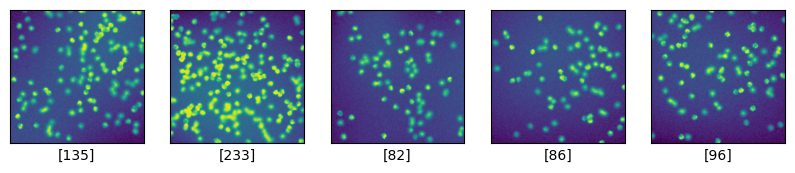

In [ ]:
#plot 3 images
plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_samples[i])
    plt.xlabel(train_labels[i])


## Data Augmentation and preprocessing

In [ ]:
from torch.utils.data import Dataset

default_train_transforms = transforms.Compose(
    [transforms.ToPILImage(), # because the input dtype is numpy.ndarray
     transforms.RandomVerticalFlip(p=0.2), # Randomly flip the image vertically with probability of 0.2
     transforms.RandomHorizontalFlip(p=0.2), # Randomly flip the image horizontally with probability of 0.2
    transforms.RandomRotation(degrees=45), # Randomly rotate the image by 45 degrees counter-clockwise
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), # Randomly apply affine transformation of translation of 0.1
     transforms.ToTensor()
     ])

default_val_transforms = transforms.Compose(
    [transforms.ToTensor()])


class MyDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = np.array(data)
        self.targets = torch.FloatTensor(targets)
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]

        if self.transform:
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)

train_dataset = MyDataset(train_samples, train_labels, transform=default_train_transforms)
val_dataset = MyDataset(test_samples, test_labels, transform=default_val_transforms)


dataloader = {
    'train': torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True),
    'val': torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False)
  }

In [ ]:
for inputs, labels in dataloader['train']:
    print(inputs[0])
    print(labels)
    break

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
tensor([[173.],
        [143.],
        [244.],
        [129.],
        [207.],
        [250.],
        [190.],
        [162.],
        [134.],
        [ 93.],
        [200.],
        [ 92.],
        [ 83.],
        [159.],
        [206.],
        [252.]])


In [ ]:
# Check for the availability of a GPU, and use CPU otherwise
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
dataset_sizes = {"train": len(train_samples),
                 "val": len(test_samples)}
print('dataset_sizes: ', dataset_sizes)


dataset_sizes:  {'train': 180, 'val': 20}


Training and evaluation functions:

In [ ]:
def train_model(model, dataloader, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Init variables that will save info about the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_mse = np.inf
    best_mae = np.inf
    training_results = {p: [] for p in ['train', 'val']}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # Set model to training mode.
                model.train()
            else:
                # Set model to evaluate mode. In evaluate mode, we don't perform backprop and don't need to keep the gradients
                model.eval()

            running_loss = 0.
            running_mae = 0.
            runnin_squared_error = 0.

            # Iterate over data
            for inputs, labels in dataloader[phase]:
                # Prepare the inputs for GPU/CPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # ===== forward pass ======
                with torch.set_grad_enabled(phase=='train'):
                    # If we're in train mode, we'll track the gradients to allow back-propagation
                    preds = model(inputs) # apply the model to the inputs
                    loss = criterion(preds, labels)

                    # ==== backward pass + optimizer step ====
                    # This runs only in the training phase
                    if phase == 'train':
                        loss.backward() # Perform a step in the opposite direction of the gradient
                        optimizer.step() # Adapt the optimizer

                # Collect statistics
                running_loss += loss.item() * inputs.size(0)
                # print(f"Running loss: {running_loss}")
                runnin_squared_error += torch.sum(torch.pow(preds - labels, 2)).data
                # print(f"Running SE: {runnin_squared_error}")
                error = torch.abs(preds - labels).sum().data
                running_mae += error
                # print(f"Running MAE: {running_mae}")


            if phase == 'train':
                # Adjust the learning rate based on the scheduler
                scheduler.step()


            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_mae = running_mae / dataset_sizes[phase]
            epoch_mse = runnin_squared_error / dataset_sizes[phase]
            training_results[phase].append({'epoch': epoch, 'epoch_loss': epoch_loss, 'epoch_mse': epoch_mse})

            print(f'{phase} Loss(MSE): {epoch_loss:.4f} MAE: {epoch_mae:.4f}')

            # Keep the results of the best model so far
            if phase == 'val' and epoch_mae < best_mae:
                best_mse = epoch_mse
                best_mae = epoch_mae
                # deepcopy the model
                best_model_wts = copy.deepcopy(model.state_dict())


    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best val MSE: {best_mse:4f}')
    print(f'Best val MAE: {best_mae:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, training_results


### We will start with some base model because we want to make sure our model learns well ,and then we will try to improve it and make it more complex  


In [ ]:
class BaseNetwork(nn.Module):
    def __init__(self):
        super(BaseNetwork, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, 5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 32, 5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        self.layer3 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU()
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )


        self.layer5 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Flatten()
        )

        self.dropout1 = nn.Dropout(p=0.2)

        self.fc1 = nn.Sequential(
            nn.Linear(64 * 64 * 64, 256),
            nn.ReLU()
        )

        self.dropout2 = nn.Dropout(p=0.2)

        self.fc2 = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU()
        )

        self.fc3 = nn.Sequential(
            nn.Linear(128, 1),
            nn.ReLU()
        )


    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.dropout1(out)
        out = self.fc1(out)
        out = self.dropout2(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

In [ ]:
model = BaseNetwork().to(device)
print(model)

BaseNetwork(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer3): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer5): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): ReLU()
    (2): Flatten(start_dim=1, end_dim=-1)
  )
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc1): Sequential(
 

In [ ]:
from torchsummary import summary
summary(model.to(device), (1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             832
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 256, 256]          25,632
       BatchNorm2d-5         [-1, 32, 256, 256]              64
              ReLU-6         [-1, 32, 256, 256]               0
         MaxPool2d-7         [-1, 32, 128, 128]               0
              ReLU-8         [-1, 32, 128, 128]               0
            Conv2d-9         [-1, 64, 128, 128]          18,496
      BatchNorm2d-10         [-1, 64, 128, 128]             128
             ReLU-11         [-1, 64, 128, 128]               0
        MaxPool2d-12           [-1, 64, 64, 64]               0
             ReLU-13           [-1, 64, 64, 64]               0
          Flatten-14               [-1,

In [ ]:
criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.0001)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

num_epochs = 20

base_results = []

model, stats = train_model(model,
                  dataloader,
                  criterion,
                  optimizer,
                  exp_lr_scheduler,
                  num_epochs=num_epochs)


Epoch 0/19
----------
train Loss(MSE): 11697.2886 MAE: 85.8693
val Loss(MSE): 20099.8465 MAE: 125.9101
Epoch 1/19
----------
train Loss(MSE): 1696.2503 MAE: 31.7854
val Loss(MSE): 22788.8227 MAE: 137.2089
Epoch 2/19
----------
train Loss(MSE): 900.8325 MAE: 23.4705
val Loss(MSE): 19969.8227 MAE: 128.6219
Epoch 3/19
----------
train Loss(MSE): 608.5440 MAE: 18.8750
val Loss(MSE): 17424.7797 MAE: 121.3262
Epoch 4/19
----------
train Loss(MSE): 445.1387 MAE: 15.5764
val Loss(MSE): 11441.6808 MAE: 98.4846
Epoch 5/19
----------
train Loss(MSE): 471.4900 MAE: 17.1270
val Loss(MSE): 5405.5461 MAE: 67.9195
Epoch 6/19
----------
train Loss(MSE): 369.1766 MAE: 15.0374
val Loss(MSE): 1219.7820 MAE: 31.9903
Epoch 7/19
----------
train Loss(MSE): 338.3210 MAE: 14.0931
val Loss(MSE): 87.6964 MAE: 6.7602
Epoch 8/19
----------
train Loss(MSE): 299.8884 MAE: 13.3830
val Loss(MSE): 73.2614 MAE: 7.1894
Epoch 9/19
----------
train Loss(MSE): 401.7173 MAE: 15.4992
val Loss(MSE): 244.7123 MAE: 13.5570
Epoch

### Final Accuracy in the Base Model is 87.7 MSE and 6.7 MAE

In [ ]:
def results_df(stats):
    train_stats_df = pd.DataFrame(stats['train'])
    train_stats_df['Dataset'] = 'train'
    train_stats_df.epoch_mse = train_stats_df.epoch_mse.apply(
        lambda x: x.cpu().detach().numpy())
    val_stats_df = pd.DataFrame(stats['val'])
    val_stats_df['Dataset'] = 'validation'
    val_stats_df.epoch_mse = val_stats_df.epoch_mse.apply(
        lambda x: x.cpu().detach().numpy())
    return pd.concat([train_stats_df, val_stats_df]).reset_index(drop=True)


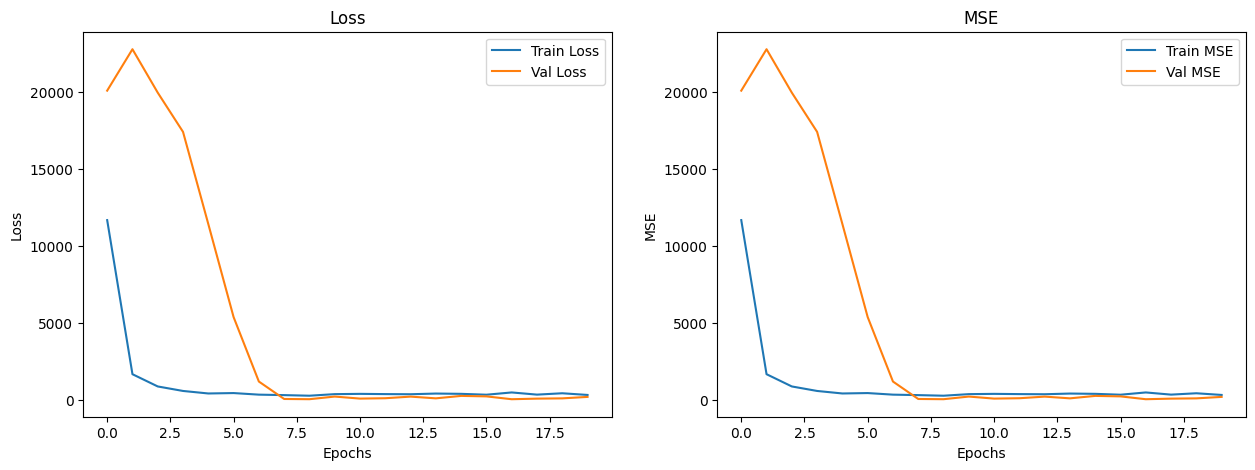

In [ ]:
def plot_results(stats):
    stats = results_df(stats)
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    train_loss = stats[stats["Dataset"] == "train"]["epoch_loss"].values
    val_loss = stats[stats["Dataset"] == "validation"]["epoch_loss"].values
    train_mse = stats[stats["Dataset"] == "train"]["epoch_mse"].values
    val_mse = stats[stats["Dataset"] == "validation"]["epoch_mse"].values

    axs[0].plot(train_loss, label="Train Loss")
    axs[0].plot(val_loss, label="Val Loss")
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Loss")
    axs[0].set_title("Loss")
    axs[0].legend()

    axs[1].plot(train_mse, label="Train MSE")
    axs[1].plot(val_mse, label="Val MSE")
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("MSE")
    axs[1].set_title("MSE")
    axs[1].legend()

    plt.show()

plot_results(stats)

### Architecture


In [ ]:
class CnnNetwork(nn.Module):
    def __init__(self):
        super(CnnNetwork, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, 5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 32, 5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        self.layer3 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU()
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.layer6 = nn.Sequential(
            nn.Conv2d(64, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.layer7 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU()
        )

        self.layer8 = nn.Sequential(
            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.layer9 = nn.Sequential(
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.layer10 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Flatten()
        )

        self.dropout1 = nn.Dropout(p=0.3)

        self.fc1 = nn.Sequential(
            nn.Linear(128 * 32 * 32, 1024),
            nn.ReLU()
        )

        self.dropout2 = nn.Dropout(p=0.3)

        self.fc2 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU()
        )

        self.fc3 = nn.Sequential(
            nn.Linear(512, 16),
            nn.ReLU()
        )

        self.fc4 = nn.Sequential(
            nn.Linear(16, 1),
            nn.ReLU()
        )


    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.dropout1(out)
        out = self.fc1(out)
        out = self.dropout2(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        return out

In [ ]:
from torchsummary import summary
summary(CnnNetwork().to(device), (1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             832
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 256, 256]          25,632
       BatchNorm2d-5         [-1, 32, 256, 256]              64
              ReLU-6         [-1, 32, 256, 256]               0
         MaxPool2d-7         [-1, 32, 128, 128]               0
              ReLU-8         [-1, 32, 128, 128]               0
            Conv2d-9         [-1, 64, 128, 128]          18,496
      BatchNorm2d-10         [-1, 64, 128, 128]             128
             ReLU-11         [-1, 64, 128, 128]               0
           Conv2d-12         [-1, 64, 128, 128]          36,928
      BatchNorm2d-13         [-1, 64, 128, 128]             128
             ReLU-14         [-1, 64, 1

In [ ]:
torch.cuda.empty_cache()

In [ ]:
model = CnnNetwork().to(device)

criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.0001)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

num_epochs = 20

base_results = []

model, stats = train_model(model,
                  dataloader,
                  criterion,
                  optimizer,
                  exp_lr_scheduler,
                  num_epochs=num_epochs)


Epoch 0/19
----------
train Loss(MSE): 15968.2777 MAE: 102.8349
val Loss(MSE): 30810.1031 MAE: 162.8312
Epoch 1/19
----------
train Loss(MSE): 1233.4735 MAE: 25.7456
val Loss(MSE): 30681.1063 MAE: 162.3705
Epoch 2/19
----------
train Loss(MSE): 599.3357 MAE: 18.2526
val Loss(MSE): 25275.3203 MAE: 144.9909
Epoch 3/19
----------
train Loss(MSE): 391.2525 MAE: 14.9880
val Loss(MSE): 21575.2957 MAE: 132.4519
Epoch 4/19
----------
train Loss(MSE): 554.6948 MAE: 17.9110
val Loss(MSE): 15730.1113 MAE: 113.4445
Epoch 5/19
----------
train Loss(MSE): 315.3458 MAE: 13.2782
val Loss(MSE): 6913.9784 MAE: 76.3042
Epoch 6/19
----------
train Loss(MSE): 285.9983 MAE: 12.9294
val Loss(MSE): 1828.0443 MAE: 39.7766
Epoch 7/19
----------
train Loss(MSE): 367.7083 MAE: 14.4957
val Loss(MSE): 253.5479 MAE: 13.9797
Epoch 8/19
----------
train Loss(MSE): 244.0191 MAE: 12.2959
val Loss(MSE): 59.0823 MAE: 5.4832
Epoch 9/19
----------
train Loss(MSE): 353.4866 MAE: 14.6381
val Loss(MSE): 41.0000 MAE: 5.0773
Epo

### Final Accuracy this config is 45.66 MSE and 4.9 MAE

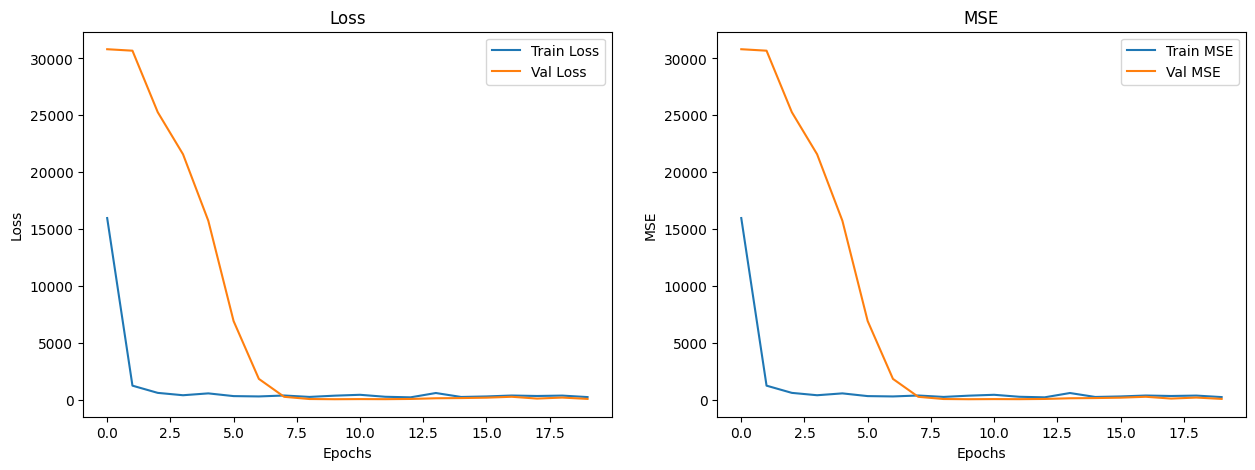

In [ ]:
# Plotting the results
plot_results(stats)

In [ ]:
def train_model(model, dataloader, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Init variables that will save info about the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_mse = np.inf
    best_mae = np.inf
    training_results = {p: [] for p in ['train', 'val']}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # Set model to training mode.
                model.train()
            else:
                # Set model to evaluate mode. In evaluate mode, we don't perform backprop and don't need to keep the gradients
                model.eval()

            running_loss = 0.
            running_mae = 0.
            runnin_squared_error = 0.

            # Iterate over data
            for inputs, labels in dataloader[phase]:
                # Prepare the inputs for GPU/CPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # ===== forward pass ======
                with torch.set_grad_enabled(phase=='train'):
                    # If we're in train mode, we'll track the gradients to allow back-propagation
                    preds = model(inputs) # apply the model to the inputs
                    loss = criterion(preds, labels)

                    # ==== backward pass + optimizer step ====
                    # This runs only in the training phase
                    if phase == 'train':
                        loss.backward() # Perform a step in the opposite direction of the gradient
                        optimizer.step() # Adapt the optimizer

                # Collect statistics
                running_loss += loss.item() * inputs.size(0)
                # print(f"Running loss: {running_loss}")
                runnin_squared_error += torch.sum(torch.pow(preds - labels, 2)).data
                # print(f"Running SE: {runnin_squared_error}")
                error = torch.abs(preds - labels).sum().data
                running_mae += error
                # print(f"Running MAE: {running_mae}")


            if phase == 'train':
                # Adjust the learning rate based on the scheduler
                scheduler.step(metrics=running_loss)


            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_mae = running_mae / dataset_sizes[phase]
            epoch_mse = runnin_squared_error / dataset_sizes[phase]
            training_results[phase].append({'epoch': epoch, 'epoch_loss': epoch_loss, 'epoch_mse': epoch_mse})

            print(f'{phase} Loss(MSE): {epoch_loss:.4f} MAE: {epoch_mae:.4f}')

            # Keep the results of the best model so far
            if phase == 'val' and epoch_mae < best_mae:
                best_mse = epoch_mse
                best_mae = epoch_mae
                # deepcopy the model
                best_model_wts = copy.deepcopy(model.state_dict())


    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best val MSE: {best_mse:4f}')
    print(f'Best val MAE: {best_mae:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, training_results


In [ ]:
model = CnnNetwork().to(device)

criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.0003)

exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)

num_epochs = 30

base_results = []

model, stats = train_model(model,
                  dataloader,
                  criterion,
                  optimizer,
                  exp_lr_scheduler,
                  num_epochs=num_epochs)

Epoch 0/29
----------
train Loss(MSE): 9590.6541 MAE: 72.5009
val Loss(MSE): 32217.5414 MAE: 167.0806
Epoch 1/29
----------
train Loss(MSE): 1060.5768 MAE: 26.3361
val Loss(MSE): 28253.9648 MAE: 154.8009
Epoch 2/29
----------
train Loss(MSE): 429.7769 MAE: 16.6823
val Loss(MSE): 23679.9867 MAE: 139.3556
Epoch 3/29
----------
train Loss(MSE): 779.4092 MAE: 22.4806
val Loss(MSE): 21369.1699 MAE: 130.6557
Epoch 4/29
----------
train Loss(MSE): 448.4018 MAE: 16.0626
val Loss(MSE): 20160.2313 MAE: 131.1821
Epoch 5/29
----------
train Loss(MSE): 643.1318 MAE: 20.7425
val Loss(MSE): 11323.6530 MAE: 99.5435
Epoch 6/29
----------
train Loss(MSE): 518.7970 MAE: 17.7799
val Loss(MSE): 939.0410 MAE: 29.1254
Epoch 7/29
----------
train Loss(MSE): 380.7914 MAE: 15.0880
val Loss(MSE): 953.9238 MAE: 28.7917
Epoch 8/29
----------
train Loss(MSE): 490.2503 MAE: 17.4647
val Loss(MSE): 91.6267 MAE: 6.9500
Epoch 9/29
----------
train Loss(MSE): 512.4057 MAE: 17.2640
val Loss(MSE): 108.8106 MAE: 7.4439
Epoc

### Final Accuracy this config is 54.5 MSE and 5.65 MAE

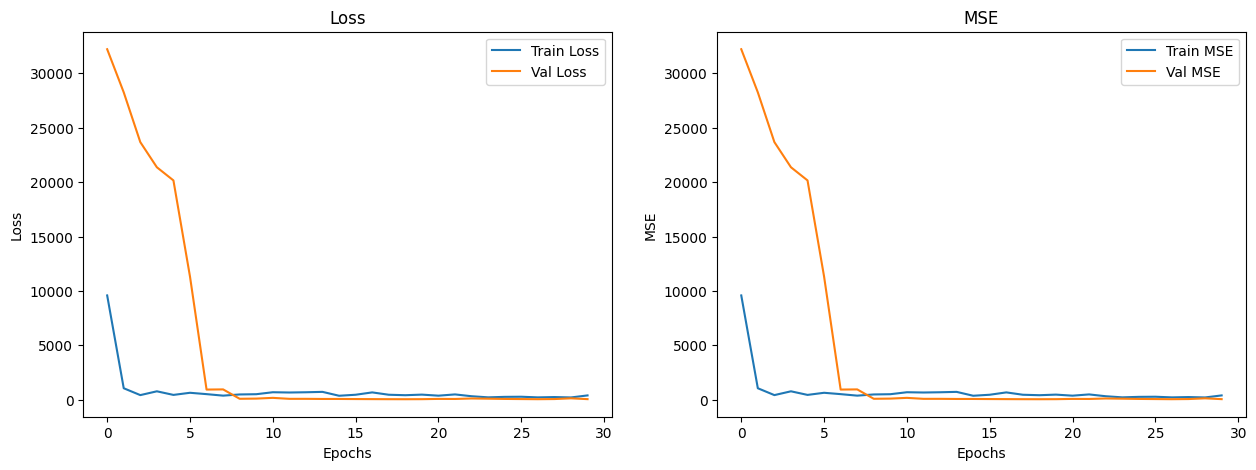

In [ ]:
plot_results(stats)

### take a look at the filters

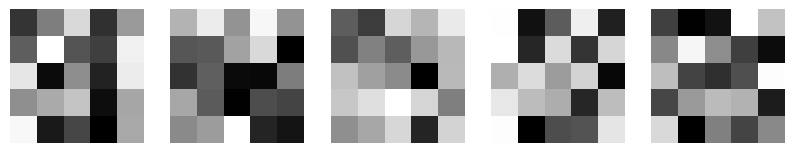

In [ ]:
filter_layer_1 = model.layer1[0].weight.data.cpu().numpy()
filter_layer_2 = model.layer2[0].weight.data.cpu().numpy()

f_min, f_max = filter_layer_1.min(), filter_layer_1.max()
filters = (filter_layer_1 - f_min) / (f_max - f_min)

plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1,
                 5, i+1)
    plt.imshow(filters[i][0], cmap='gray')
    plt.axis('off')
plt.show()

## Final Accuracy this config is 45.66 MSE and 4.9 MAE

The final architecture is:

10 convolutional layers with batch normalization and ReLU activation, followed by max pooling layers in the third and seventh layers. The network ends with three fully connected (dense) layers, each followed by a ReLU activation and a dropout layer.

The network takes as input grayscale images with dimensions (1, height, width) and produces a single output prediction.

The number of filters used in each convolutional layer is 32, 64, 64, and 128, respectively, and the size of the filters is 5x5 in the first two layers and 3x3 in the remaining ones. The stride used in all convolutional layers is 1, and the padding is 2 in the first two layers and 1 in the rest.

The first fully connected layer has 1024 units, the second has 512, and the third has 16. Finally, the output layer has a single unit with a ReLU activation.

In addition, we used data augmentation to increase the size of the training set and reduce overfitting. The transformations applied to the training set include random horizontal and vertical flips, random rotation, and affine transformation of translation.

Our final configuration includes 20 epochs, a batch size of 64, and a learning rate of 0.001. The loss function used is the mean squared error (MSE), and the optimizer is Adam.

